MATH628  
Group 4

# Data Specifications

* stock_prices.csv: Includes the daily closing price for each stock and the target column.
* options.csv: The status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import ROUND_HALF_UP, Decimal
import scipy.stats as si

import warnings
warnings.filterwarnings('ignore')

# Stock Price EDA

In [2]:
origin_dir = r"D:\UMICH\Semester 2\MATH 628\final project\project\data"
my_dir = r"D:\UMICH\Semester 2\MATH 628\final project\project\data\train_files"

## Load stock_prices data and missing values processing

In [3]:
stock_df = pd.read_csv(os.path.join(my_dir, 'stock_prices.csv'), parse_dates=["Date"])

In [4]:
stock_df_missing = stock_df[stock_df['Close'].isna()]
print(f"The number of missing values of Close: {len(stock_df_missing)}")

The number of missing values of Close: 7608


<Axes: >

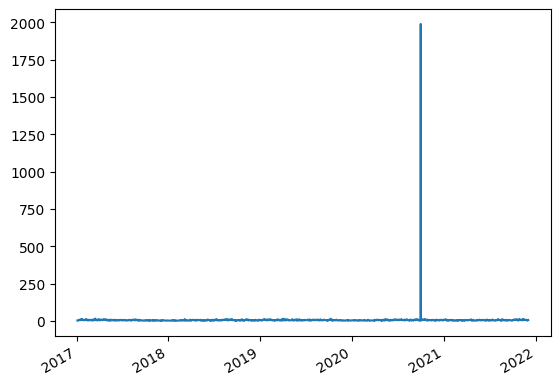

In [5]:
stock_df_missing["Date"].value_counts().plot()

We found that there is a huge number of missing data in 2020-10-01 due to the failure of equity trading system of JPX.  
Hence, dropping NAN values directly will have little impact to the whole dataset.

In [6]:
stock_df.drop(index=stock_df_missing.index, inplace=True)
stock_df.reset_index(drop=True, inplace=True)

## Adjust price data
We adjust the close price, then We will not use the "expectedDividend", "AdjustmentFactor", and "SupervisionFlag" columns, drop them.

In [7]:
def adjust_price(price):
    """reference: https://www.kaggle.com/code/metathesis/feature-engineering-training-with-ta/notebook#Introduction-of-features-using-stock-price-data"""
    # set date to standard format
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")
    
    def generate_adjusted_close(df):
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    
    price.set_index("Date", inplace=True)
    return price

In [8]:
stock_df = adjust_price(stock_df)
stock_df.drop(columns=["AdjustmentFactor", "ExpectedDividend", "SupervisionFlag"], inplace=True)

In [9]:
stock_df

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,Target,CumulativeAdjustmentFactor,AdjustedClose
Date,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,0.000730,1.0,2742.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,0.002920,1.0,2738.0
2017-01-06,20170106_1301,1301,2734.0,2744.0,2720.0,2740.0,19900,-0.001092,1.0,2740.0
2017-01-10,20170110_1301,1301,2745.0,2754.0,2735.0,2748.0,24200,-0.005100,1.0,2748.0
2017-01-11,20170111_1301,1301,2748.0,2752.0,2737.0,2745.0,9300,-0.003295,1.0,2745.0
...,...,...,...,...,...,...,...,...,...,...
2021-11-29,20211129_9997,9997,678.0,679.0,665.0,668.0,320800,0.026987,1.0,668.0
2021-11-30,20211130_9997,9997,670.0,689.0,667.0,667.0,296300,-0.001460,1.0,667.0
2021-12-01,20211201_9997,9997,661.0,688.0,660.0,685.0,339100,0.017544,1.0,685.0


## Primary Keys

### RowId, Date, SecuritiesCode
`RowId`: Unique ID of price records, the combination of `Date` and `SecuritiesCode`.  
`Date`: Trade date.  
`SecuritiesCode`: Local securities code.

In [10]:
print(f"The number of unique dates: {stock_df.index.nunique()}")
print(f"The number of unique securities: {stock_df['SecuritiesCode'].nunique()}")

The number of unique dates: 1201
The number of unique securities: 2000


### Target
`Target`: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is trade date.

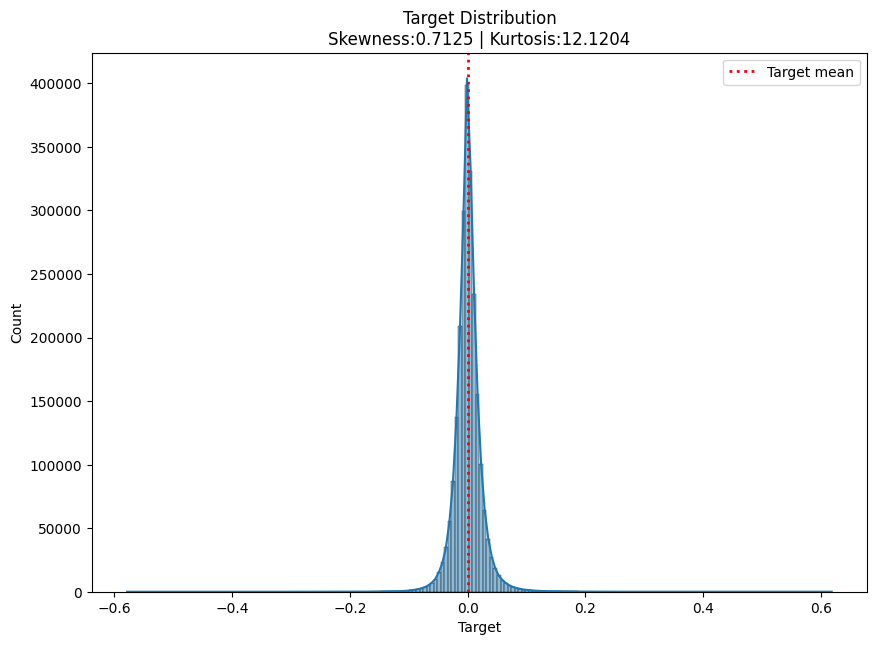

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=stock_df["Target"].values, bins=200, kde=True, ax=ax)
ax.axvline(x=stock_df["Target"].values.mean(), color="red", linestyle=":", linewidth=2, label="Target mean")
ax.set_title("Target Distribution\n" 
              f"Skewness:{round(stock_df['Target'].skew(), 4)} | Kurtosis:{round(stock_df['Target'].kurtosis(), 4)}")
ax.set_xlabel("Target")
ax.legend()
plt.show()

Target distribution is slightly right-skewed with a very large kurtosis. Large kurtosis indicates that the distribution of targets has a very high peak and very heavy tails, and the probability of extreme value of targets is much higher. We need to pay attention to the tail risk.

### OHLCV
`Open`: First traded price on a day.  
`High`: Highest traded price on a day.  
`Low`: Lowest traded price on a day.  
`Close`: Last traded price on a day.  
`Volume`: Number of traded stocks on a day.

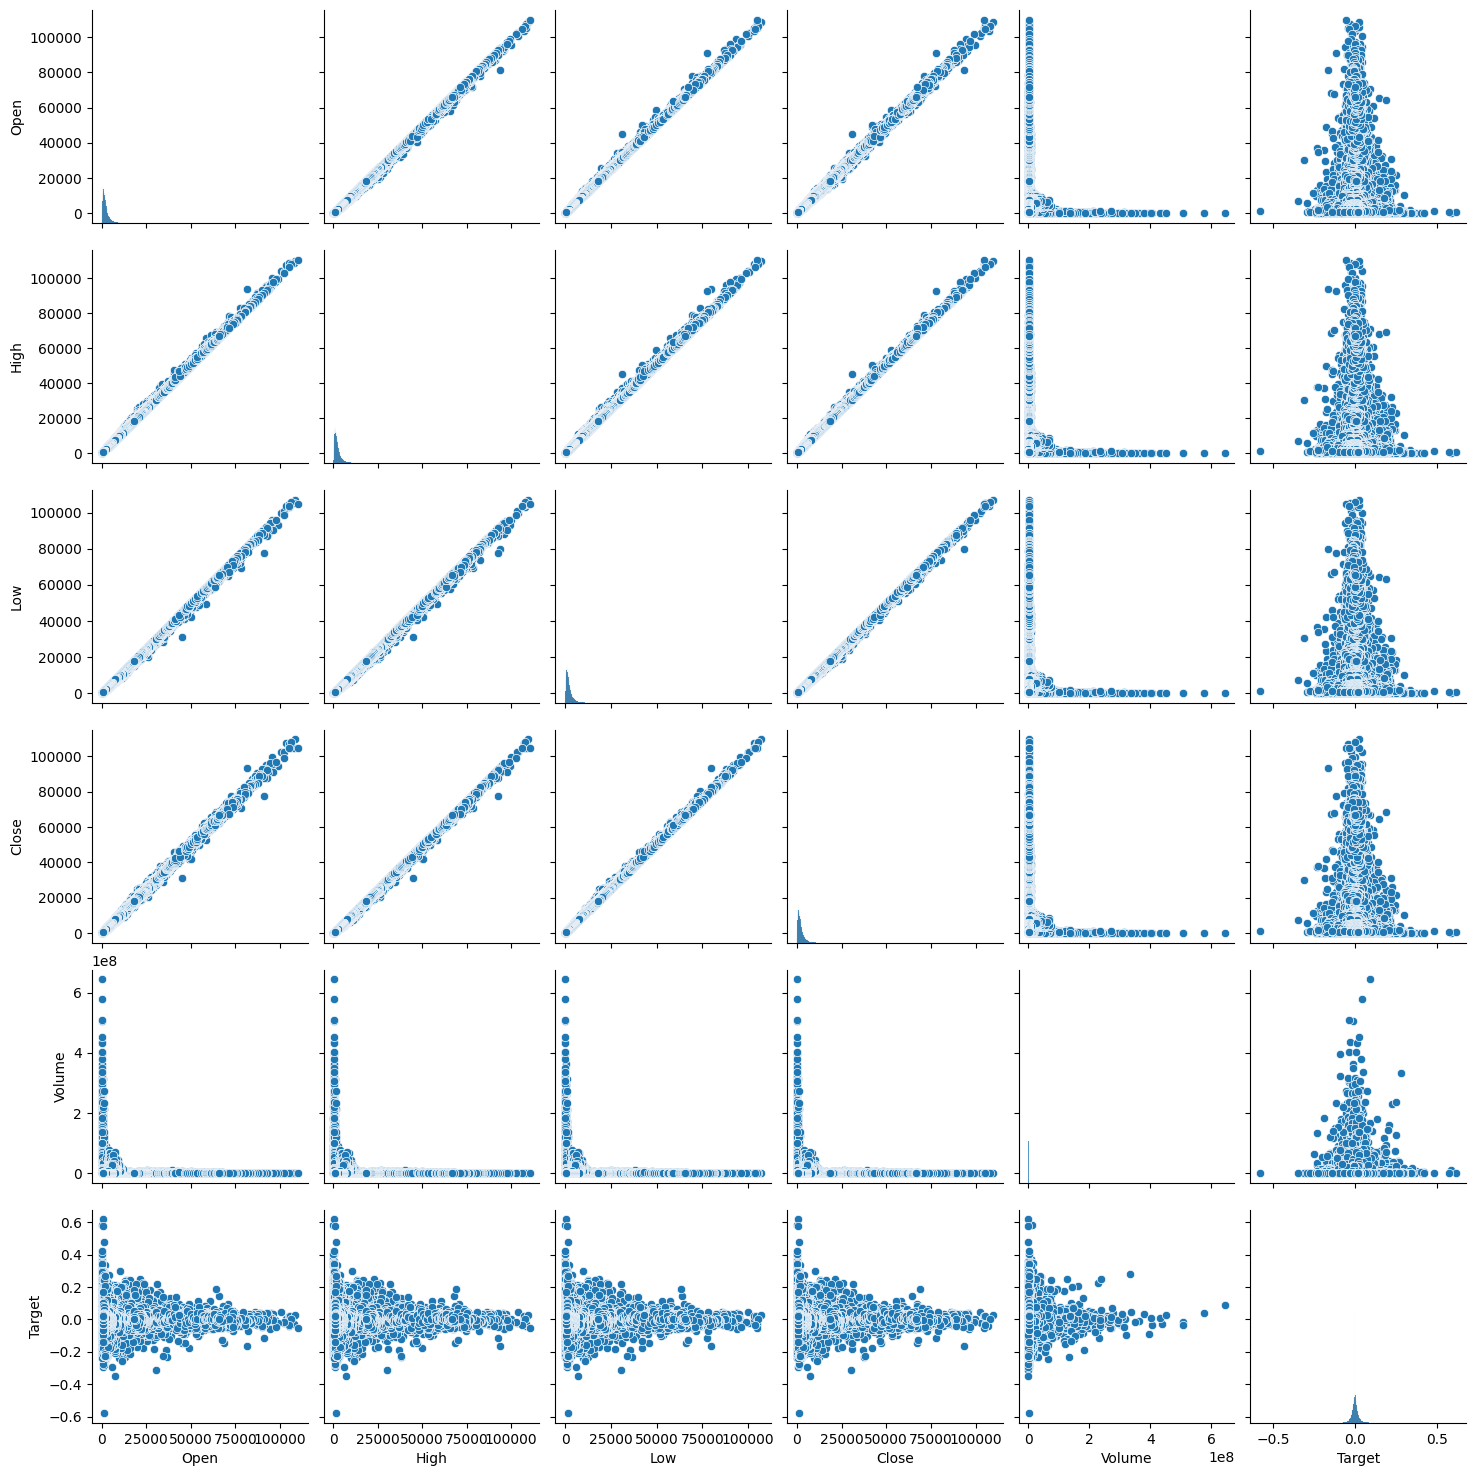

In [12]:
sns.pairplot(stock_df[["Open", "High", "Low", "Close", "Volume", "Target"]])

<Axes: >

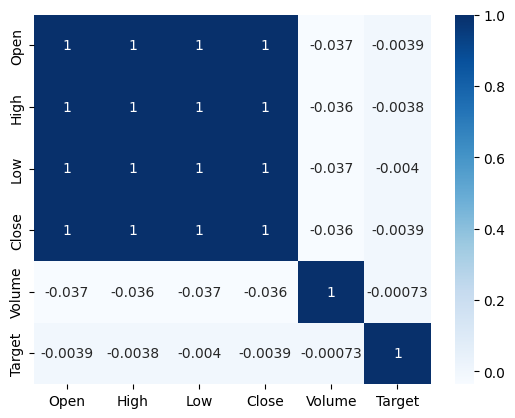

In [13]:
sns.heatmap(stock_df[["Open", "High", "Low", "Close", "Volume", "Target"]].corr(), cmap="Blues", annot=True)

In [14]:
%%time
feats_stock = pd.DataFrame(stock_df[["SecuritiesCode", "Target"]], index=stock_df.index)

feats_stock["return_10d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(10)
feats_stock["return_20d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(20)
feats_stock["return_30d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(30)
feats_stock["return_40d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(40)
feats_stock["return_50d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(50)
feats_stock["return_60d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(60)
feats_stock["return_70d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(70)
feats_stock["return_80d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(80)
feats_stock["return_90d"] = stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"]).pct_change(90)
feats_stock["MA_10d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(10).mean()["AdjustedClose"]
feats_stock["MA_20d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(20).mean()["AdjustedClose"]
feats_stock["MA_30d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(30).mean()["AdjustedClose"]
feats_stock["MA_40d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(40).mean()["AdjustedClose"]
feats_stock["MA_50d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(50).mean()["AdjustedClose"]
feats_stock["MA_60d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(60).mean()["AdjustedClose"]
feats_stock["MA_70d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(70).mean()["AdjustedClose"]
feats_stock["MA_80d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(80).mean()["AdjustedClose"]
feats_stock["MA_90d"] = stock_df["AdjustedClose"] / stock_df[["SecuritiesCode", "AdjustedClose"]].groupby(["SecuritiesCode"], as_index=False).rolling(90).mean()["AdjustedClose"]

CPU times: total: 2.33 s
Wall time: 5.86 s


<Axes: >

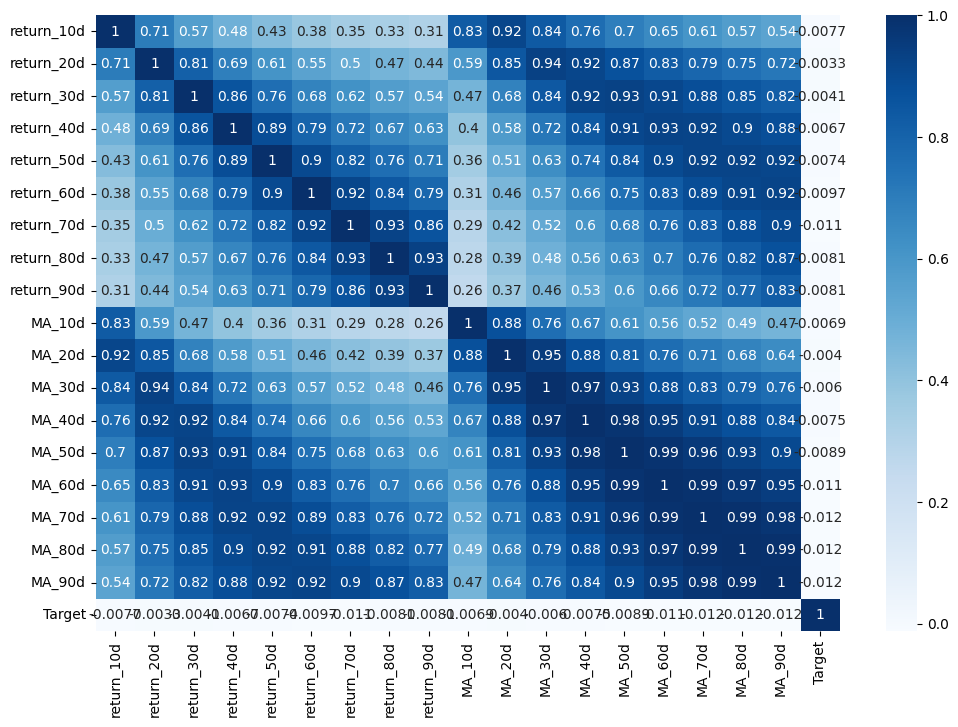

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(feats_stock[["return_10d", "return_20d", "return_30d", "return_40d", "return_50d", "return_60d", "return_70d", "return_80d", "return_90d", 
                         "MA_10d", "MA_20d", "MA_30d", "MA_40d", "MA_50d", "MA_60d", "MA_70d", "MA_80d", "MA_90d", "Target"]].corr(), 
            cmap="Blues", annot=True, ax=ax)

From correlation heatmap, we will choose the factors with high correlation with the target.  
`return_10d`  
`return_60d`  
`return_70d`  
`return_90d`  
`MA_10d`  
`MA_40d`  
`MA_50d`  
`MA_90d`

In [16]:
%%time
feats_stock["volatility_10d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(10).std()
feats_stock["volatility_20d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(20).std()
feats_stock["volatility_30d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(30).std()
feats_stock["volatility_40d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(40).std()
feats_stock["volatility_50d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(50).std()
feats_stock["volatility_60d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(60).std()
feats_stock["volatility_70d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(70).std()
feats_stock["volatility_80d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(80).std()
feats_stock["volatility_90d"] = np.log(stock_df[["SecuritiesCode", "AdjustedClose"]]).groupby(["SecuritiesCode"], as_index=False)["AdjustedClose"].diff().rolling(90).std()

CPU times: total: 812 ms
Wall time: 2.07 s


<Axes: >

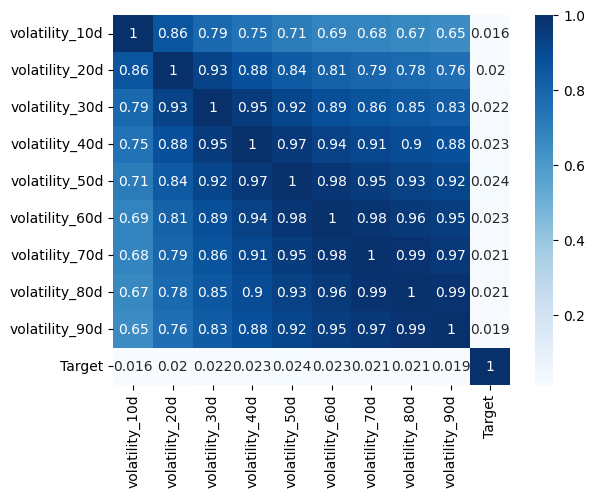

In [42]:
sns.heatmap(feats_stock[["volatility_10d", "volatility_20d", "volatility_30d", "volatility_40d", "volatility_50d", "volatility_60d", "volatility_70d", "volatility_80d", "volatility_90d", "Target"]].corr(), 
            cmap="Blues", annot=True)

We will choose  
`volatility_20d`  
`volatility_50d`  
`volatility_60d`  
`volatility_80d`  

# Option EDA

## Load options data

In [20]:
options_df = pd.read_csv(os.path.join(my_dir, 'options.csv'), parse_dates=["Date"])

In [21]:
options_df.head()

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0
3,20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,795.0,791.0383,17.4736,15.2288,0.0091,0.0,0.0
4,20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,910.0,909.9947,17.4736,14.5932,0.0091,0.0,0.0


In [22]:
options_df.columns

Index(['DateCode', 'Date', 'OptionsCode', 'WholeDayOpen', 'WholeDayHigh',
       'WholeDayLow', 'WholeDayClose', 'NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose', 'TradingVolume',
       'OpenInterest', 'TradingValue', 'ContractMonth', 'StrikePrice',
       'WholeDayVolume', 'Putcall', 'LastTradingDay', 'SpecialQuotationDay',
       'SettlementPrice', 'TheoreticalPrice', 'BaseVolatility',
       'ImpliedVolatility', 'InterestRate', 'DividendRate', 'Dividend'],
      dtype='object')

In [23]:
print(f"The number of unique option contracts: {options_df['OptionsCode'].nunique()}")
print(f"The number of unique dates: {options_df['Date'].nunique()}")

The number of unique option contracts: 14732
The number of unique dates: 1202


There is no missing values for options.

## Primary keys

### Optioncode
Local securities code.  
Consist of 9 digits.

* 1st digit: special transaction ('1' is set to indicate special transactions.
* 2nd digit: put/call, spot/futures distinction  
        put options (futures): 1 and 5
        call options (futures): 2 and 7
        put options (spot): 3 and 8
        call options (spot): 4 and 9
        futures transaction: 6
* 3rd-5th digits: contract year (10-year cycle) and month
* 6th-7th digits: Exercise price (strike price)
* 8th-9th digits: underlying index

All options are special transaction (start from '1'), and all are spot transactions. The underlying index is 18 for all options.

In [27]:
options_df.OptionsCode.apply(lambda x: x%100).value_counts()

18    3567694
Name: OptionsCode, dtype: int64

All options have only one underlying: Nikkei Stock Average (Nikkei 225)  https://www.jpx.co.jp/english/sicc/regulations/b5b4pj0000023mqo-att/(HP)sakimono20220208-e.pdf

In [28]:
stock_list = pd.read_csv(os.path.join(origin_dir, 'stock_list.csv'))

In [29]:
"""reference: https://www.kaggle.com/code/lucasmorin/jpx-eda-feature-engineering-options/notebook#Put-/-call"""
s = stock_list['Name'].str.lower()
name = 'nikkei'
number = '225'
lv = ['bear','bull','leveraged','double','inverse','futures','50','mini','smdam','nzam']

Nikkei_ETFs = stock_list[s.str.contains(name) & s.str.contains(number) & ~(s.str.contains('|'.join(lv)))]
Nikkei_ticker_list = Nikkei_ETFs.SecuritiesCode.unique()

In [30]:
Nikkei_ETFs

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
9,1320,20211230,Daiwa ETF-Nikkei 225,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,29725.0,128910559.0,3.831866e+12,False
10,1321,20211230,NEXT FUNDS Nikkei 225 Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,29770.0,267573465.0,7.965662e+12,False
17,1329,20211230,iShares Core Nikkei 225 ETF,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,29910.0,31756418.0,9.498345e+11,False
23,1346,20211230,MAXIS NIKKEI225 ETF,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,29910.0,64756054.0,1.936854e+12,False
36,1369,20211230,One ETF Nikkei225,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,28970.0,13106598.0,3.796981e+11,False
673,2624,20211230,iFreeETF-Nikkei225(Quarterly Dividend Type),ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2887.0,5778400.0,1.668224e+10,False


In [31]:
Nikkei_ticker_list

array([1320, 1321, 1329, 1346, 1369, 2624], dtype=int64)

#### Research ETF

In [32]:
etf_df = pd.read_csv(os.path.join(my_dir, 'secondary_stock_prices.csv'))

In [33]:
etf_df = etf_df[etf_df.SecuritiesCode.isin(Nikkei_ticker_list)]

In [34]:
etf_df = adjust_price(etf_df)

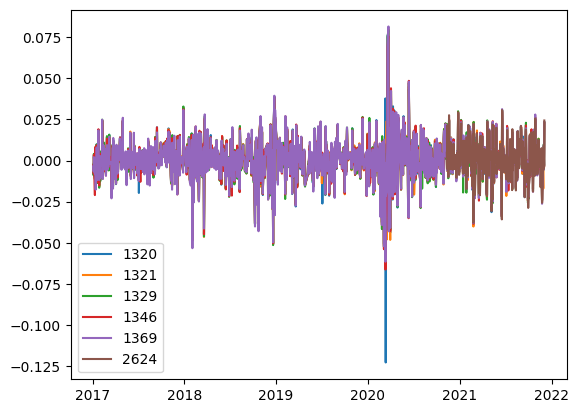

In [35]:
pivot_etf_df = etf_df.pivot(columns='SecuritiesCode')['Target']
plt.plot(pivot_etf_df)
plt.legend(pivot_etf_df.columns, loc="lower left")

In [36]:
etf_df[["SecuritiesCode", "Target"]].pivot(columns="SecuritiesCode").corr()

Target                                          \
SecuritiesCode             1320      1321      1329      1346      1369   
       SecuritiesCode                                                     
Target 1320            1.000000  0.920829  0.934816  0.911793  0.905071   
       1321            0.920829  1.000000  0.976570  0.965969  0.966651   
       1329            0.934816  0.976570  1.000000  0.980864  0.975147   
       1346            0.911793  0.965969  0.980864  1.000000  0.976185   
       1369            0.905071  0.966651  0.975147  0.976185  1.000000   
       2624            0.978153  0.966636  0.975591  0.980365  0.981993   

                                 
SecuritiesCode             2624  
       SecuritiesCode            
Target 1320            0.978153  
       1321            0.966636  
       1329            0.975591  
       1346            0.980365  
       1369            0.981993  
       2624            1.000000

For these ETF, the returns are highly correlated. So we can only pick one as the underlying asset. We should choose the one that is traded liquidly.

In [37]:
etf_df.groupby('SecuritiesCode')['Volume'].mean()

SecuritiesCode
1320     64437.234609
1321    316460.860233
1329     19636.678037
1346     33927.370216
1369      3086.826123
2624     12322.587786
Name: Volume, dtype: float64

Thus, it is better to choose 1321 as the underlying asset.

In [38]:
underlying_etf = etf_df[etf_df.SecuritiesCode.isin([1321])]
underlying_etf.drop(columns=["AdjustmentFactor", "ExpectedDividend", "SupervisionFlag", "CumulativeAdjustmentFactor"], inplace=True)

In [39]:
underlying_etf.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,Target,AdjustedClose
Date,,,,,,,,,
2017-01-04,20170104_1321,1321,19790.0,20100.0,19780.0,20080.0,749647,-0.003497,20080.0
2017-01-05,20170105_1321,1321,20100.0,20120.0,19960.0,20020.0,679991,-0.006516,20020.0
2017-01-06,20170106_1321,1321,19850.0,19980.0,19830.0,19950.0,474555,0.002018,19950.0
2017-01-10,20170110_1321,1321,19910.0,19980.0,19750.0,19820.0,388580,-0.011078,19820.0
2017-01-11,20170111_1321,1321,19860.0,19890.0,19830.0,19860.0,351023,0.007637,19860.0


### WholeDay, NightSession, DaySession OHLC
* WholeDayOpen: Opening price for whole trading day.
* WholeDayHigh: Highest price for whole trading day.
* WholeDayLow: Lowest price for whole trading day.
* WholeDayClose: Closing price for whole trading day.
* NightSessionOpen: Opening price for night session.
* NightSessionHigh: Highest price for night session.
* NightSessionLow: Lowest price for night session.
* NightSessionClose: Closing price for night session.
* DaySessionOpen: Opening price for day session.
* DaySessionHigh: Highest price for day session.
* DaySessionLow: Lowest price for day session.
* DaySessionClose: Closing price for day session.

### TradingVolume and TradingValue
* TradingVolume: Trading volume of the product/contract for the whole trading day.    
Stock price movements aren’t always what they appear. Beneath the surface of a move higher or lower, trends may be forming—or fizzling into a reversal. Trading volume measures the number of shares traded during time period.  
* TradingValue: Trading value of the product/contract for the whole trading day.  
Trading Value means the average closing sales price

### OpenInterest and InterestRate
* OpenInterest: Open interest of the product/contract for the whole trading day.  
Open interest is the total number of outstanding derivative contracts, such as options or futures that have not been settled for an asset.
* InterestRate: Interest rate for calculation.

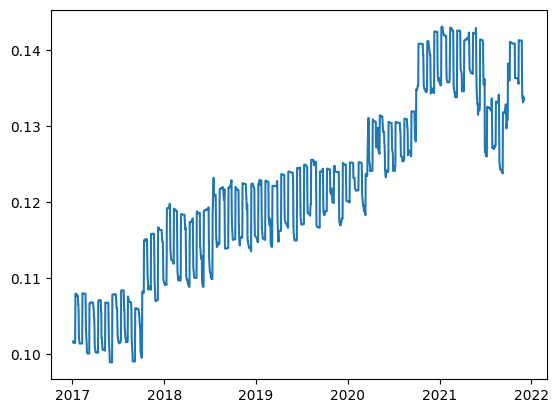

In [40]:
plt.plot(options_df.groupby(["Date"])[["InterestRate"]].mean())

### ContractMonth
* ContractMonth: Cotract year-month of the product/contract.

### StrikePrice, TheoreticalPrice, SettlementPrice
* StrikePrice: Exercise price of product/contract.
* SettlementPrice: Settlement price.
* TheoreticalPrice: The theoretical price at the end of a day session.  
The theoretical value (of a right) is the value of a subscription right.

#### StrikePrice

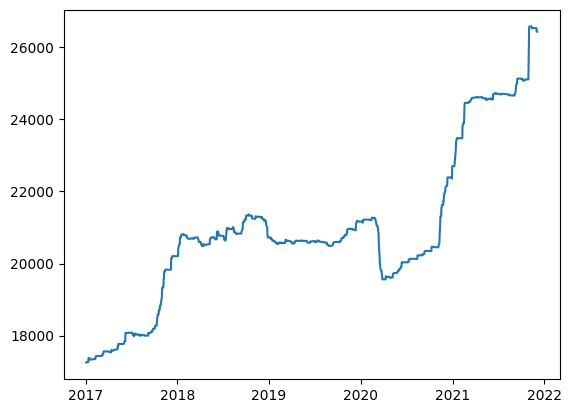

In [41]:
strike = options_df[["Date", "StrikePrice"]].groupby(["Date"]).mean()
plt.plot(strike)

We should find how many options are in the money (the current price of underlying asset is above the strike price for call, below for put). Then if an option is in the money, investor will exercise right now to make money, which will cause the underlying price goes down I guess (since the current prices are overestimated).

`Moneyness`

In [42]:
strike_price = pd.merge(options_df.set_index("Date")[["Putcall", "StrikePrice"]], underlying_etf["AdjustedClose"], right_index=True, left_index=True)
strike_price["Putcall"] = strike_price["Putcall"].apply(lambda x: -1 if x==1 else 1)

In [43]:
strike_price["moneyness"] = (strike_price["Putcall"] * (strike_price["AdjustedClose"]-strike_price["StrikePrice"])) > 0

In [44]:
strike_price.head()

,Putcall,StrikePrice,AdjustedClose,moneyness
Date,,,,
2017-01-04,-1,20000.0,20080.0,False
2017-01-04,-1,20125.0,20080.0,True
2017-01-04,-1,20250.0,20080.0,True
2017-01-04,-1,20375.0,20080.0,True
2017-01-04,-1,20500.0,20080.0,True


In [45]:
# group each day to see the ratio
exercise_ratio = strike_price.reset_index()[["Date", "moneyness"]].groupby(["Date"]).mean()
exercise_ratio.rename(columns={"moneyness": "ratio"}, inplace=True)

In [46]:
exercise_ratio.head()

,ratio
Date,
2017-01-04,0.5
2017-01-05,0.5
2017-01-06,0.5
2017-01-10,0.5
2017-01-11,0.5


Most of the exercise ratio is 50%, it is interesting since if the ratio is not 50%, there probably occurs something different in the whole market! Let's find it.

In [47]:
np.where(exercise_ratio!=0.5)[0]

array([  55,   92,  101,  111,  130,  131,  136,  189,  197,  239,  281,
        283,  340,  346,  361,  373,  484,  519,  541,  605,  615,  667,
        675,  695,  729,  761,  773,  791,  798,  811,  829,  831,  843,
        857,  865,  890, 1000, 1002, 1006, 1033, 1036, 1045, 1046, 1048,
       1053, 1062, 1082, 1084, 1143, 1144, 1146, 1147, 1148, 1150, 1153,
       1154, 1174, 1176, 1181, 1182, 1188, 1194], dtype=int64)

In [48]:
len(np.where(exercise_ratio!=0.5)[0]) / len(exercise_ratio)

0.051580698835274545

Only 5.16% days when the exercise ratio is not balanced! It is possible to be an important feature.  

In addition, we could pay attention to the standard deviation of strike prices! Since the higher std of strike prices may imply bigger volatility of the underlying stock price. Discounted!

`strike_std`

In [50]:
options_df.loc[: ,"LastTradingDay"] = pd.to_datetime(options_df.loc[: ,"LastTradingDay"], format="%Y%m%d")
options_df["ExpireDays"] = (options_df["LastTradingDay"] - options_df["Date"]).apply(lambda x: x.days)

In [65]:
std_strike = options_df.reset_index()[["Date", "StrikePrice", "ExpireDays", "InterestRate"]]
# we should discount strike price K here
std_strike["DiscountedStrike"] = std_strike["StrikePrice"] * np.exp(-std_strike["InterestRate"]*std_strike["ExpireDays"])
strike_vol = std_strike[["Date", "DiscountedStrike"]].groupby(["Date"]).std()

<Axes: xlabel='Date'>

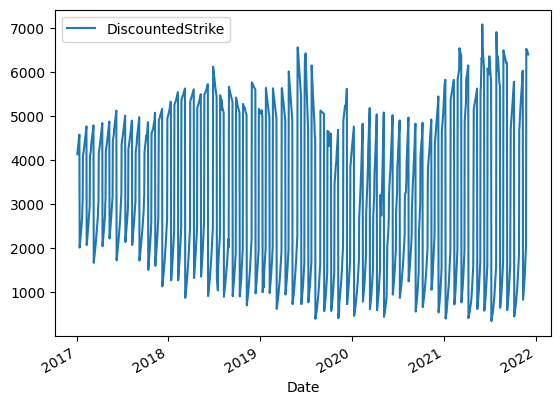

In [67]:
strike_vol.plot()

#### SettlementPrice and TheoreticalPrice
Settlement Price denotes the current price of the option contracts. We can compute the difference between settlementPrice and TheoreticalPrice to present the liquidity of the option contract! as a feature as well.

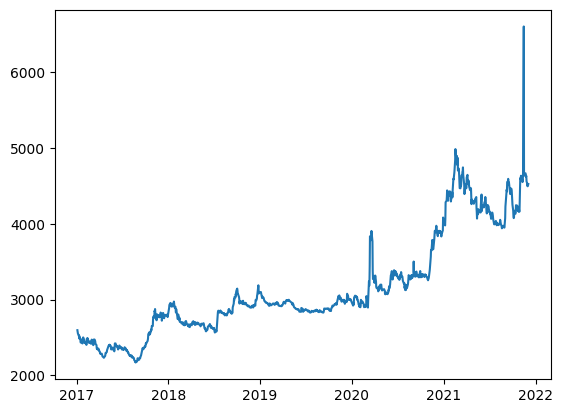

In [68]:
settlement_price = options_df[["Date", "SettlementPrice"]].groupby(["Date"]).mean()
plt.plot(settlement_price)

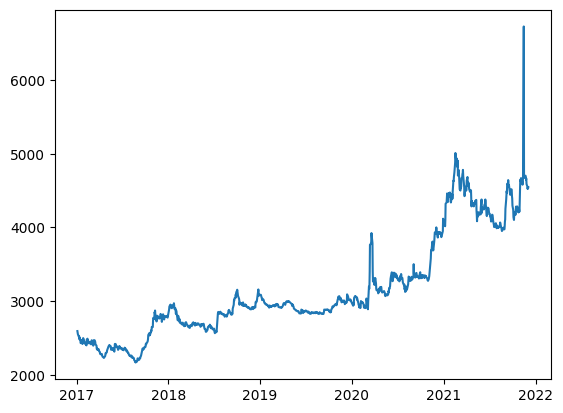

In [69]:
theoretical_price = options_df[["Date", "TheoreticalPrice"]].groupby(["Date"]).mean()
plt.plot(theoretical_price)

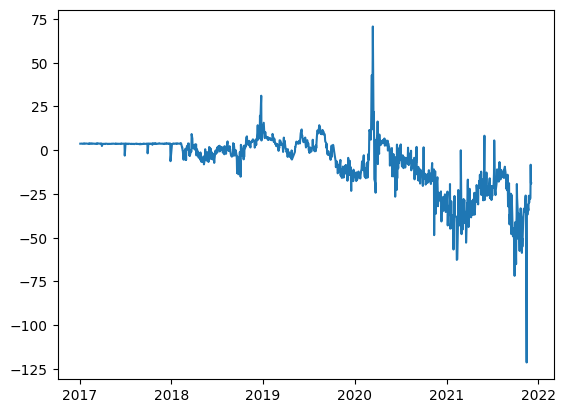

In [70]:
diff_s_t = options_df["SettlementPrice"] - options_df["TheoreticalPrice"]
diff_s_t = pd.concat([options_df["Date"], pd.DataFrame(diff_s_t, columns=["liquidity"])], axis=1)
diff_s_t = diff_s_t.groupby(["Date"]).mean()
plt.plot(diff_s_t)

It could be a useful feature, let's discuss it.

### BaseVolatility, ImpliedVolatility
* BaseVolatility: The volatility at the time of calculating the settlement price.
* ImpliedVolatility: Implied volatility.

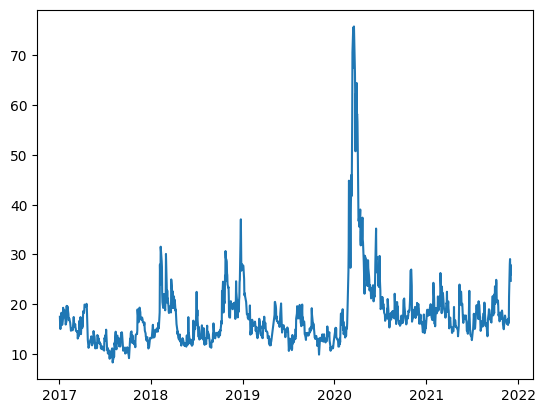

In [71]:
base_volatility = options_df[["Date", "BaseVolatility"]].groupby(["Date"]).mean()
plt.plot(base_volatility)

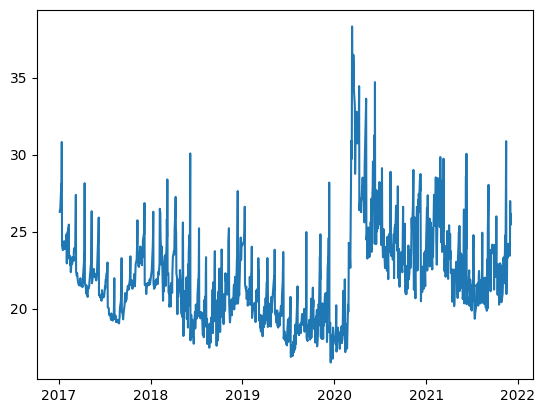

In [72]:
Implied_volatility = options_df[["Date", "ImpliedVolatility"]].groupby(["Date"]).mean()
plt.plot(Implied_volatility)

We can use basevolatility as historical volatility, and impliedvolatility as two important features directly. 

We can consider the impliedVolatility of put and call seperately, that is implied volatility skewness: the ratio of the implied volatility of out-of-the-money call options to that of out-of-the-money put options.

`impliedvol_skewness`

In [73]:
implied_vol = pd.merge(options_df.set_index("Date")[["Putcall", "StrikePrice", "ImpliedVolatility"]], underlying_etf["AdjustedClose"], right_index=True, left_index=True)
implied_vol["Putcall"] = implied_vol["Putcall"].apply(lambda x: -1 if x==1 else 1)

In [74]:
implied_vol_otm_call = implied_vol.apply(lambda x: x[2] if (x[0]==1 and x[3]<x[1]) else 0, axis=1)
implied_vol_otm_put = implied_vol.apply(lambda x: x[2] if (x[0]==-1 and x[3]>x[1]) else 0, axis=1)

In [75]:
implied_skewness = implied_vol_otm_call.reset_index().groupby(["Date"]).mean() / implied_vol_otm_put.reset_index().groupby(["Date"]).mean()
implied_skewness.rename(columns={0: "implied_skewness"}, inplace=True)

<Axes: xlabel='Date'>

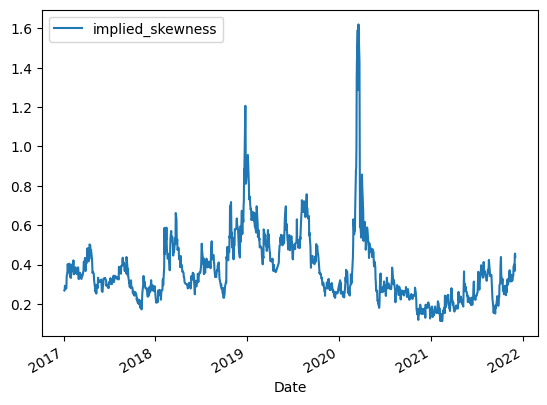

In [76]:
implied_skewness.plot()

### DividendRate and Dividend
* DividendRate: Dividend yeild.
* Dividend: Dividend.

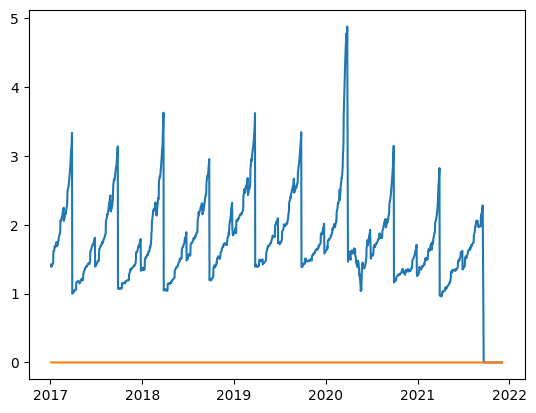

In [77]:
plt.plot(options_df.groupby(["Date"])[["DividendRate", "Dividend"]].mean())

### Put/Call
* Putcall: 1 for put and 2 for call.

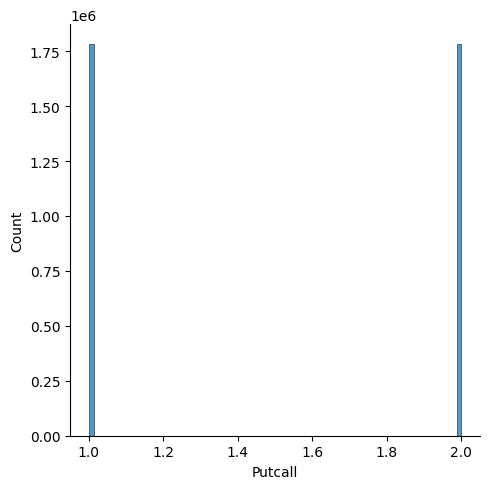

In [78]:
sns.displot(options_df["Putcall"])

The number of put and call contracts are almost the same, but we still need to see the trading volume of the two contracts.

In [79]:
trading_volume = options_df[['Date', 'Putcall', 'TradingVolume']].groupby(['Date', 'Putcall']).sum().unstack()
trading_volume = trading_volume["TradingVolume"]
trading_volume.rename(columns={1: "Put", 2: "Call"}, inplace=True)

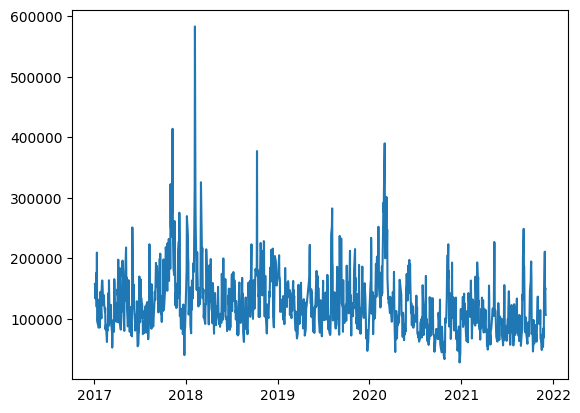

In [80]:
total_volume = (trading_volume["Put"]+trading_volume["Call"])
plt.plot(total_volume)

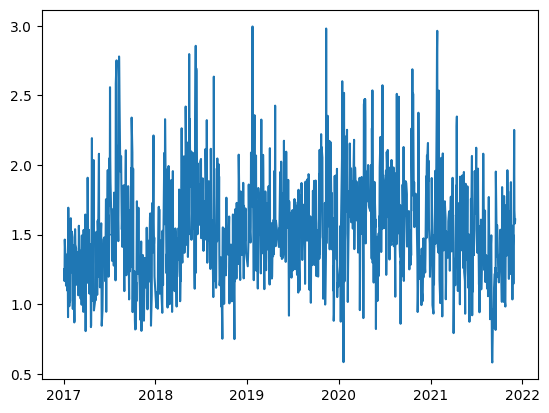

In [81]:
put_call_ratio = trading_volume["Put"] / trading_volume["Call"]
plt.plot(put_call_ratio)

There exists an obvious imbalance between put and call trading volumes. The volumes of put options are more than call options, it means investors usually traded put options to hedge the market downward risk.

## Zero values

In [82]:
zero_ratio_cols = (options_df==0).sum() / len(options_df)

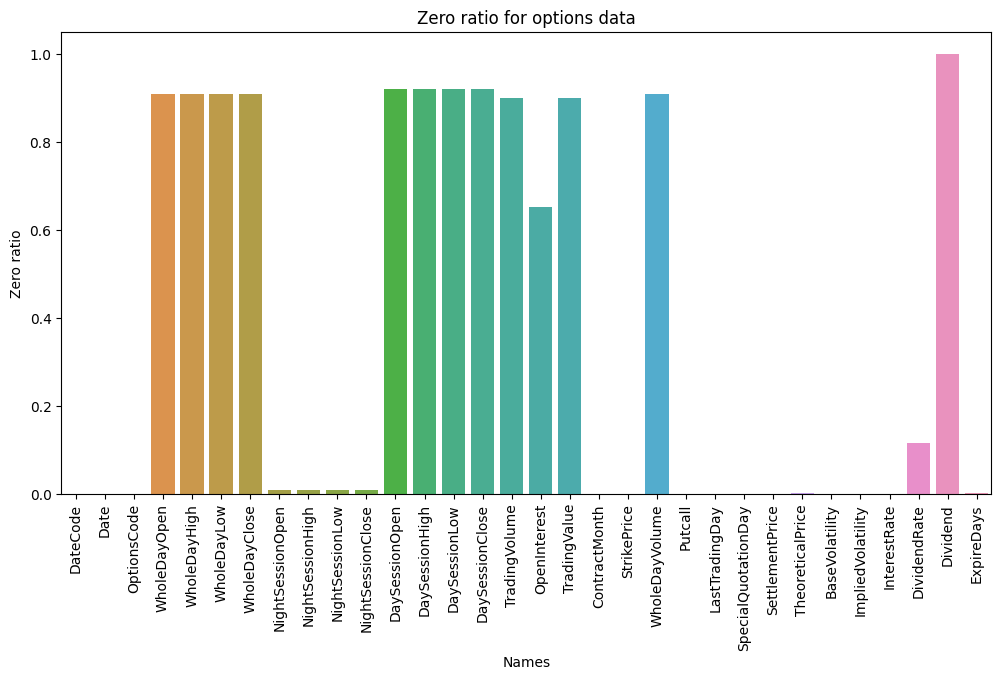

In [83]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=zero_ratio_cols.index, y=zero_ratio_cols.values, ax=ax)
ax.set_title("Zero ratio for options data")
ax.set_xlabel("Names")
ax.set_ylabel("Zero ratio")
ax.tick_params(axis='x', rotation=90)
plt.show()

There are high zero ratios in WholeDay prices, DaySession prices, Trading volume and value, and dividend. 

## Greeks (BS Model without dividend)
Greeks are the sensitivities of option price without dividend based on Black-Scholes Model.

In [84]:
def d(s, k, r, T, sigma):
    d1 = (np.log(s/k) + (r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return (d1, d2)

Problem: here sigma is historical volatility, or implied volatility, or the sum?

Compute s, k, r, T, sigma respectively.

In [85]:
options_df.loc[: ,"LastTradingDay"] = pd.to_datetime(options_df.loc[: ,"LastTradingDay"], format="%Y%m%d")

In [86]:
options_df["ExpireDays"] = (options_df["LastTradingDay"] - options_df["Date"]).apply(lambda x: x.days)

In [87]:
bs_params = pd.merge(options_df.set_index("Date")[["Putcall", "StrikePrice", "BaseVolatility", "ImpliedVolatility", "InterestRate", "ExpireDays"]], underlying_etf["AdjustedClose"], right_index=True, left_index=True)
bs_params["Putcall"] = bs_params["Putcall"].apply(lambda x: -1 if x==1 else 1)
bs_params.head()

,Putcall,StrikePrice,BaseVolatility,ImpliedVolatility,InterestRate,ExpireDays,AdjustedClose
Date,,,,,,,
2017-01-04,-1,20000.0,17.4736,17.5865,0.0091,8,20080.0
2017-01-04,-1,20125.0,17.4736,16.5000,0.0091,8,20080.0
2017-01-04,-1,20250.0,17.4736,15.8644,0.0091,8,20080.0
2017-01-04,-1,20375.0,17.4736,15.2288,0.0091,8,20080.0
2017-01-04,-1,20500.0,17.4736,14.5932,0.0091,8,20080.0


In [89]:
s = bs_params["AdjustedClose"]
k = bs_params["StrikePrice"]
r = bs_params["InterestRate"]
T = bs_params["ExpireDays"]
sigma = bs_params["ImpliedVolatility"]
putcall = bs_params["Putcall"]

### Delta
sensitivity of option price to underlying price

In [90]:
def delta(s, k, r, T, sigma, putcall):
    # putcall==-1: put; putcall==1: call
    (d1, d2) = d(s, k, r, T, sigma)
    delta = putcall * si.norm.cdf(putcall*d1)
    delta.rename("delta", inplace=True)
    return delta

In [91]:
options_delta = delta(s, k, r, T, sigma, putcall)

In [92]:
options_delta.head()

Date
2017-01-04   -7.362964e-137
2017-01-04   -9.551986e-121
2017-01-04   -8.555095e-112
2017-01-04   -3.420884e-103
2017-01-04    -6.107907e-95
Name: delta, dtype: float64

<Axes: xlabel='Date'>

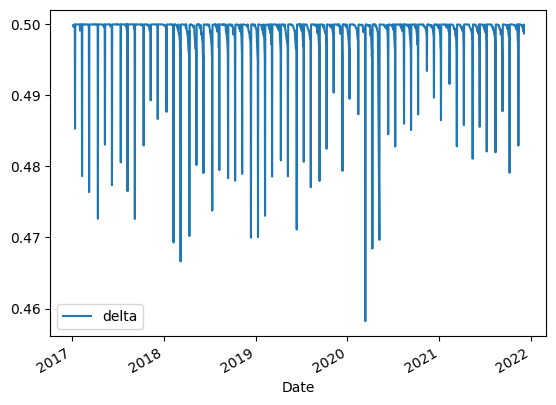

In [93]:
options_delta.reset_index().groupby(["Date"]).mean().plot()

### Gamma
sensitivity of Delta to underlying price

In [94]:
def gamma(s, k, r, T, sigma):
    (d1, d2) = d(s, k, r, T, sigma)
    gamma = si.norm.pdf(d1) / (s*sigma*np.sqrt(T))
    gamma.rename("gamma", inplace=True)
    return gamma

In [95]:
options_gamma = gamma(s, k, r, T, sigma)
options_gamma.head()

Date
2017-01-04    1.836475e-141
2017-01-04    2.382989e-125
2017-01-04    2.134604e-116
2017-01-04    8.536957e-108
2017-01-04     1.524540e-99
Name: gamma, dtype: float64

<Axes: xlabel='Date'>

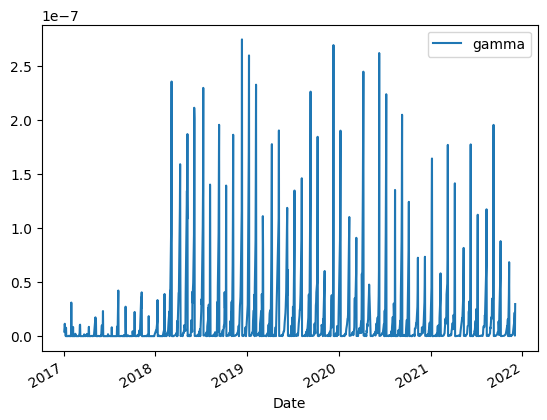

In [96]:
options_gamma.reset_index().groupby(["Date"]).mean().plot()

### Vega
sensitivity of option price to underlying volatility.

In [97]:
def vega(s, k, r, T, sigma):
    (d1, d2) = d(s, k, r, T, sigma)
    vega = (s*si.norm.pdf(d1) * np.sqrt(T))
    vega.rename("vega", inplace=True)
    return vega

In [98]:
options_vega = vega(s, k, r, T, sigma)
options_vega.head()

Date
2017-01-04    1.041794e-130
2017-01-04    1.268304e-114
2017-01-04    1.092341e-105
2017-01-04     4.193592e-97
2017-01-04     7.176403e-89
Name: vega, dtype: float64

<Axes: xlabel='Date'>

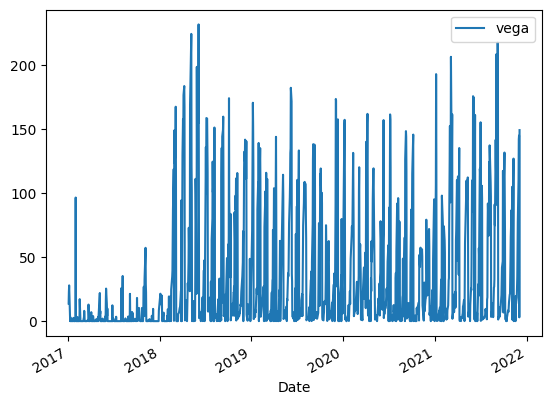

In [99]:
options_vega.reset_index().groupby(["Date"]).mean().plot()

### Theta
sensitivity of option price to time passing by.

In [100]:
def theta(s, k, r, T, sigma, putcall):
    (d1, d2) = d(s, k, r, T, sigma)
    theta = (-1*(s*si.norm.pdf(d1)*sigma) / (2*np.sqrt(T)) - putcall*r*k*np.exp(-r*T)*si.norm.cdf(putcall*d2)) / 365
    theta.rename("theta", inplace=True)
    return theta

In [101]:
options_theta = theta(s, k, r, T, sigma, putcall)
options_theta.head()

Date
2017-01-04    0.463620
2017-01-04    0.466517
2017-01-04    0.469415
2017-01-04    0.472313
2017-01-04    0.475210
Name: theta, dtype: float64

<Axes: xlabel='Date'>

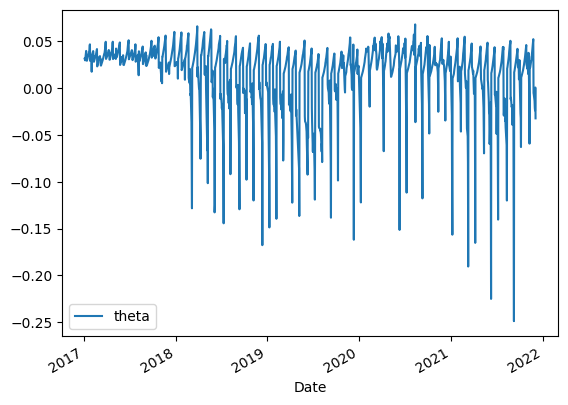

In [102]:
options_theta.reset_index().groupby(["Date"]).mean().plot()